In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Read csv and standardize NaNs:

In [41]:
# csv imported fom https://huggingface.co/datasets/ailsntua/Chordonomicon/blob/main/chordonomicon_v2.csv
raw_df=pd.read_csv('../../data/chordonomicon_raw.csv', low_memory=False)
raw_df = raw_df.replace({np.nan: pd.NA})


In [42]:
raw_df.shape

(679807, 10)

Since we are analyzing release dates, main genre and popularity (via spotify song id), remove any entries that don't have any of these features. In the end, it seems that only 70% of the data could be useful to us.

In [43]:
clean_df=raw_df[raw_df['release_date'].notna() & raw_df['spotify_song_id'].notna() & raw_df['main_genre'].notna()]

print(clean_df.shape) 
clean_df.head()

(301564, 10)


,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
1,2,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,2003-01-01,'alternative metal' 'alternative rock' 'nu met...,2000.0,pop rock,artist_2,metal,2ffJZ2r8HxI5DHcmf3BO6c,694QW15WkebjcrWgQHzRYF
2,3,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,2003-01-01,'alternative metal' 'canadian rock' 'funk meta...,2000.0,canadian rock,artist_3,metal,5KiY8SZEnvCPyIEkFGRR3y,0niJkG4tKkne3zwr7I8n9n
4,5,<intro_1> C <verse_1> G C G C <chorus_1> F Dmi...,2023-02-10,'modern country pop',2020.0,<NA>,artist_5,pop,3zUecdrWC3IqrNSjhnoF3G,4GGfAshSkqoxpZdoaHm7ky
6,7,<intro_1> G Bmin Amin D G Bmin <verse_1> Amin ...,2023-02-10,'modern country pop',2020.0,<NA>,artist_5,pop,1gh9q0HsS3tVXQypDXp4gf,4GGfAshSkqoxpZdoaHm7ky
7,8,<intro_1> Fsmin Fsno3d Bno3d E/B Fsno3d Bno3d ...,2023-02-10,'french pop' 'nouvelle chanson francaise',2020.0,<NA>,artist_7,pop,4y3uAOMHISJ3OOdjPC1FFN,6e3pZKXUxrPfnUPJ960Hd9


The genre and by extension rock_genre labels seem too specific to be useful. To confirm, check how many unique genres are listed and view some of them

In [44]:
#find number of unique genres

import random
#since each genres entry is a list, split the list into components
newlist=[string.split("' '") for string in clean_df[clean_df.genres.notna()].genres]
#unnest all the components into one list
unnested_list=[j.strip("'") for i in newlist for j in i]
#analyze unique elements
print(len(set(unnested_list)))
print(random.sample(list(set(unnested_list)),20)) #random sample of unique genres

4113
['italian underground hip hop', 'talentschau', 'ottawa rap', 'futurepop', 'blues mexicano', 'swedish idol pop', 'soul flow', 'reggaeton chileno', 'german rock', 'dirty south rap', 'glitch pop', 'vietnamese singer-songwriter', 'frankfurt indie', 'aggrotech', 'romanian pop', 'metal ecuatoriano', 'deep dance pop', 'minimal techno', 'russian hyperpop', 'euskal indie']


There are 4992 genres and a quick glance shows many are quite specific. This information is likely too precise to be useful and will be dropped. By extension, also drop rock_genre feature. Finally, drop the 'id' feature because this has no useful information, and the artist_id features becasue the spotfiy_artist_id feature makes this redundant.

In [45]:
clean_df=clean_df.drop(columns=['id','artist_id','genres','rock_genre'])
clean_df.head()

,chords,release_date,decade,main_genre,spotify_song_id,spotify_artist_id
1,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,2003-01-01,2000.0,metal,2ffJZ2r8HxI5DHcmf3BO6c,694QW15WkebjcrWgQHzRYF
2,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,2003-01-01,2000.0,metal,5KiY8SZEnvCPyIEkFGRR3y,0niJkG4tKkne3zwr7I8n9n
4,<intro_1> C <verse_1> G C G C <chorus_1> F Dmi...,2023-02-10,2020.0,pop,3zUecdrWC3IqrNSjhnoF3G,4GGfAshSkqoxpZdoaHm7ky
6,<intro_1> G Bmin Amin D G Bmin <verse_1> Amin ...,2023-02-10,2020.0,pop,1gh9q0HsS3tVXQypDXp4gf,4GGfAshSkqoxpZdoaHm7ky
7,<intro_1> Fsmin Fsno3d Bno3d E/B Fsno3d Bno3d ...,2023-02-10,2020.0,pop,4y3uAOMHISJ3OOdjPC1FFN,6e3pZKXUxrPfnUPJ960Hd9


If we take a quick look at the decade feature, we see that decades from 1890-1940 appear very sporadically, in fact these decades combined account for less than .07% of all data with a decade listed. 

decade
2010.0    128614
2000.0     68686
1990.0     33016
2020.0     31532
1980.0     16491
1970.0     13808
1960.0      7916
1950.0      1296
1940.0        83
1930.0        58
1920.0        40
1890.0        23
1900.0         1
Name: count, dtype: int64


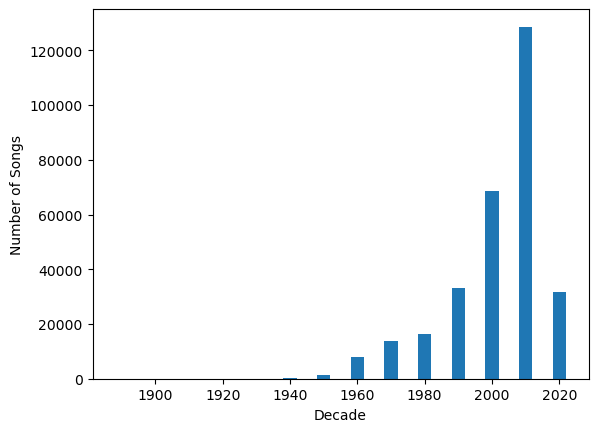

In [46]:
yrs=clean_df['decade'].value_counts()
print(yrs)
plt.bar(yrs.index,yrs,width=4)
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.show()

This class imbalance is far to large for these decades to be of any use, so we will restrict our study to decades from the 1950's on. 

In [47]:
clean_df=clean_df[(clean_df['decade']>1940) | clean_df['decade'].isna()==True]


Looking at the main_genre feature also shows some imbalance, but not as drastic as the decade feature so we retain all genres here.

main_genre
pop            72598
rock           57501
country        44902
alternative    42255
pop rock       33995
punk           14381
metal          10129
rap             8765
soul            6158
jazz            5306
reggae          3309
electronic      2060
Name: count, dtype: int64


Text(0, 0.5, 'Main Genre')

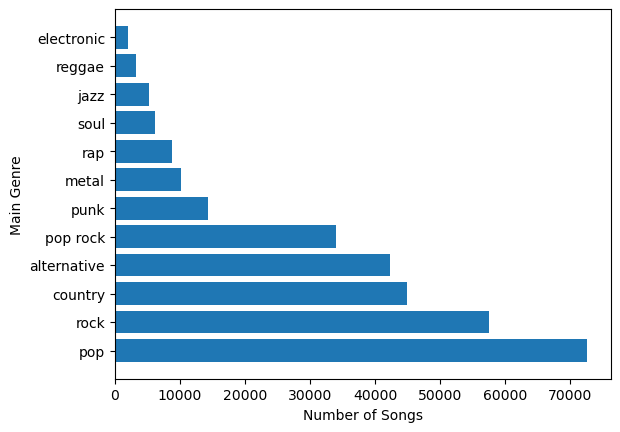

In [48]:
grs=clean_df['main_genre'].value_counts()
print(grs)
plt.barh(grs.index,grs)
plt.xlabel('Number of Songs')
plt.ylabel('Main Genre')

Create a new feature 'chord_dict' by using Juan's song_split function to separate the song sections in the 'chords' feature into dictionary entries:

In [49]:
#copy over Juan's code, edited to fix bug that occurs when two sections have the same name

import re

# regex to capture tags like <verse_1>, <chorus_2>, <bridge>, etc.
TAG = re.compile(r"<\s*([^>]+?)\s*>", flags=re.IGNORECASE)

# Given string of chords partitioned into sections, returns dictionary of sections:chords in section.
def song_split(chord_str: str):
    s = (chord_str or "").strip()

    # find all tags and their spans
    spans = [(m.group(1).strip(), m.start(), m.end()) for m in TAG.finditer(s)]
    if not spans:
        return {"whole": s}  # no tags → treat the whole thing as one section

    # sentinel for the end of the string
    spans.append(("__END__", len(s), len(s)))

    chord_dict = {}
    for (name, tag_start, tag_end), (_, next_start, _) in zip(spans, spans[1:]):
        if name == "__END__":
            break
        # Get the segment between the end of the current tag and the start of the next tag
        segment = s[tag_end:next_start].strip()
        if segment:  # only keep non-empty segments
            # If the section already exists, concatenate the new segment to the existing string
            if name in chord_dict:
                chord_dict[name] += " " + segment
            else:
                chord_dict[name] = segment

    return chord_dict

# make new 'chord_dict' feature
clean_df.insert(1,'chord_dict',clean_df['chords'].apply(song_split))



Create some more basic features:
* num_sections: number of sections the song is split into (verses, choruses, etc.)
* tot_chords: the total number of chords listed in the progression
* tot_unique_chords: number of unique chords appearing in the progression

In [50]:
# create num_sections
clean_df.insert(2,'num_sections',clean_df['chord_dict'].apply(len))


In [51]:
#helper functions to make tot_chords and tot_unique chords

def total_chord_count(dict):
    #split each sequence into a list
    nest_list=[dict[i].split() for i in dict.keys()]
    #concatenate lists
    unnest_list=[j for i in nest_list for j in i]
    return len(unnest_list)
   
def unique_chord_count(dict):
    #split each sequence into a list
    nest_list=[dict[i].split() for i in dict.keys()]
    #concatenate lists
    unnest_list=[j for i in nest_list for j in i]
    return len(set(unnest_list))



In [52]:
#create tot_chords and total_unique chords
clean_df.insert(3,'tot_chords',clean_df['chord_dict'].apply(total_chord_count))
clean_df.insert(4,'tot_unique_chords',clean_df['chord_dict'].apply(unique_chord_count))

Taking a quick peek at tot_chords, there are many entries that have only a few (<10) chord changes

In [53]:
clean_df.tot_chords.value_counts().sort_index()

tot_chords
1        84
2        34
3        69
4       126
5       332
       ... 
1551      1
1601      1
1648      1
2011      1
2261      1
Name: count, Length: 490, dtype: int64

If we are using n-grams of up to length 5 as features, then we need to remove all data entries having 5 or fewer total chords.

In [54]:
clean_df=clean_df[clean_df['tot_chords']>5]
clean_df=clean_df.reset_index(drop=True) #update row indices after removing data points
clean_df.shape

(300714, 10)

I naive measure of song complexity would be the ratio of the number of unique chords to the total number of chords. Add this feature to the data as unique_chord_density.

In [55]:
clean_df.insert(5,'unique_chord_density',clean_df['tot_unique_chords']/clean_df['tot_chords'])

By extension, the number of unique 2,3,4 and 5-grams as as a ratio to the total number of chords could also be a complexity measure. Write a helper function to create new columns for unique n-gram density.

In [56]:
def unique_n_density(dict,n):
    #split each sequence into a list
    nest_list=[dict[i].split() for i in dict.keys()]
    
    #concatenate lists
    unnest_list=[j for i in nest_list for j in i]
    unique=[]
    no_unique=0
    
    #check sequential n-grams for uniqueness
    for i in range(len(unnest_list)-n+1):
        if unnest_list[i:i+n] not in unique:
            unique.append(unnest_list[i:i+n])
            no_unique+=1
    
    return(no_unique/len(unnest_list))

Add these features to the dataset: unique_2gram_density, unique_3gram_density, unique_4gram_density, unique_5gram_density

In [57]:
clean_df.insert(6,'unique_2gram_density',clean_df['chord_dict'].apply(unique_n_density,n=2))
clean_df.insert(7,'unique_3gram_density',clean_df['chord_dict'].apply(unique_n_density,n=3))
clean_df.insert(8,'unique_4gram_density',clean_df['chord_dict'].apply(unique_n_density,n=4))
clean_df.insert(9,'unique_5gram_density',clean_df['chord_dict'].apply(unique_n_density,n=5))

Another useful measure of song complexity could be the difference between the number of unique 2-grams and number of unique chords, normalized by the total number of chords. This is because a song which repeats the same progression over and over will have the same number of unique chords and number of unique 2-grams. For example, a song that repeats I-IV-V-I over and over has three unique chords (I,IV,V) and three unique 2-grams ([I,IV],[IV,V],[V,I]). If the motif changes or the key modulates, the difference should capture this.

In [58]:
unique_diff=(clean_df['unique_2gram_density']-clean_df['unique_chord_density'])
clean_df.insert(10,'unique_2gram_difference',unique_diff)

In [19]:
clean_df.to_csv('../../data/clean.csv')